**Modelo AlexNet**<br>
Link do Colab: https://colab.research.google.com/drive/1kRZDUngwii5Ji3nyqt90IGFhjsUkWtoT#scrollTo=rFO8H-ISsASG

In [ ]:
import kagglehub
from PIL import Image
import io
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import os

In [ ]:
# Download latest version
path = kagglehub.dataset_download("borhanitrash/alzheimer-mri-disease-classification-dataset")

print("Path to dataset files:", path)

# Caminho para o dataset
train_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet'

# Carrega o parquet
df = pd.read_parquet(train_path)

Path to dataset files: /kaggle/input/alzheimer-mri-disease-classification-dataset


In [ ]:
# Label map
label_map = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}

In [ ]:
# Transforms padrão para ResNet
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],    # padrão ImageNet
                        std=[0.229, 0.224, 0.225])
])

In [ ]:
# Dataset customizado
class AlzheimerDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_bytes = self.df.iloc[idx]['image']['bytes']
        label = self.df.iloc[idx]['label']
        image = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Criação do dataset e dataloader
dataset = AlzheimerDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

A AlexNet foi introduzida em 2012 na competição **ImageNet Large Scale Visual Recognition Challenge** é um CNN e se tornou uma arquitertura de destaque para tarefa de detecção de objetos. Ela é composta por composta por **3 camadas totalmente conectados (fully connected**) e **5 camadas convolucionais**. A primeira camada é usada para inserir uma imagem filtradas de cor (vermelho, verde e azul). [1]

In [ ]:
# Modelo com ResNet18 pré-treinada
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo com AlexNet pré-treinada
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Substitui a camada final para 4 classes
# A AlexNet tem um classifier com vários layers
# Vamos modificar a última camada linear (classifier[6])
model.classifier[6] = torch.nn.Linear(model.classifier[6].in_features, 4)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 182MB/s]


Época 1/5: 100%|██████████| 320/320 [00:21<00:00, 14.57it/s]


Loss da época 1: 1.3507


Época 2/5: 100%|██████████| 320/320 [00:20<00:00, 15.26it/s]


Loss da época 2: 1.3257


Época 3/5: 100%|██████████| 320/320 [00:21<00:00, 15.15it/s]


Loss da época 3: 1.3119


Época 4/5: 100%|██████████| 320/320 [00:21<00:00, 14.59it/s]


Loss da época 4: 1.3122


Época 5/5: 100%|██████████| 320/320 [00:20<00:00, 15.45it/s]


Loss da época 5: 1.3176


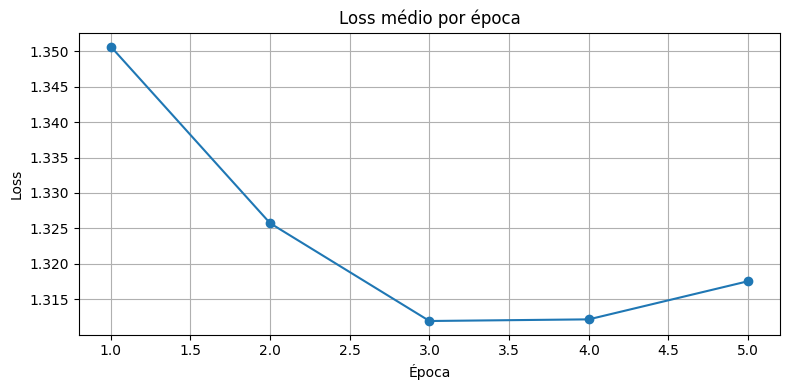

In [ ]:
# Número de exemplos por classe, na ordem dos rótulos
class_counts = torch.tensor([172, 15, 634, 459], dtype=torch.float32)

# Frequência relativa (dividido pelo total)
total = class_counts.sum()
freqs = class_counts / total

# Peso = inverso da frequência
weights = 1.0 / freqs

# Normaliza para evitar explosão de gradientes
weights = weights / weights.sum()

# Enviar para GPU
weights = weights.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from tqdm import tqdm

# Inicializa histórico
epoch_losses = []
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Loop por batch
    for images, labels in tqdm(dataloader, desc=f"Época {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Média da época
    epoch_loss = running_loss / len(dataloader)
    epoch_losses.append(epoch_loss)
    print(f"Loss da época {epoch+1}: {epoch_loss:.4f}")

# Grafico por época
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.title("Loss médio por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Caminho para o arquivo de teste
test_path = '/kaggle/input/alzheimer-mri-disease-classification-dataset/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet'

# Lê o Parquet
df_test = pd.read_parquet(test_path)

# Cria o dataset e o dataloader de teste
test_dataset = AlzheimerDataset(df_test, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Coloque o modelo em modo de avaliação
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
  for images, labels in tqdm(test_dataloader, desc="Avaliando"):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())

Avaliando: 100%|██████████| 80/80 [00:03<00:00, 23.63it/s]


In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Revocação: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Relatório completo por classe
print("\nRelatório por classe:")
print(classification_report(y_true, y_pred, target_names=[label_map[i] for i in range(4)], zero_division=0))

Acurácia: 0.4945
Precisão: 0.2455
Revocação: 0.4945
F1-score: 0.3281

Relatório por classe:
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00       172
 Moderate_Demented       0.00      0.00      0.00        15
      Non_Demented       0.50      1.00      0.66       634
Very_Mild_Demented       0.00      0.00      0.00       459

          accuracy                           0.49      1280
         macro avg       0.12      0.25      0.17      1280
      weighted avg       0.25      0.49      0.33      1280



In [ ]:
# Calcula a matriz
cm = confusion_matrix(y_true, y_pred)

# Converte para DataFrame com rótulos
cm_df = pd.DataFrame(cm, index=label_map.values(), columns=label_map.values())

print("Matriz de confusão:\n")
print(cm_df.to_string())

Matriz de confusão:

                    Mild_Demented  Moderate_Demented  Non_Demented  Very_Mild_Demented
Mild_Demented                   0                  0           170                   2
Moderate_Demented               0                  0            15                   0
Non_Demented                    0                  0           633                   1
Very_Mild_Demented              0                  0           459                   0


1. GUENKAWA, Patricia Akemi Sekini. Detecção e localização de cavitação via inteligência artificial. 2024. Tese de Doutorado. Universidade de São Paulo.